# Movie Recommendations
#### 02807 Computational tools for data science 2024

This project aims to create a Movie Recommendations System, based on IMDB scrapped data.
This goal will be achieved through 3 different methods:

The first method uses Jaccard similarity and LSH to compare Movie titles and descriptions.

The second method uses clustering via  Kmeans, to create clusters of similar movies.

The third method uses a social network approach with Adamic–Adar index.

On top of this, a machine learning model is trained on sentiment-labelled IMDB reviews, so that scrapped user reviews can be used to determine the general sentiment of a recommended movie.






# Table of Contents

Bliver genereret til sidst

## Libraries

In [1]:
import csv
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import nltk
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bs4 import BeautifulSoup
import pickle
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger_eng: <urlopen
[nltk_data]     error [Errno 11001] getaddrinfo failed>


# Loading Data

In [3]:
# Load descriptions from data/movies_metrics.csv, scrapped from IMDB using a script
Movies = pd.read_csv('movies_with_genres.csv')
Movies.head(2)

,Name,ID,Year,Length,Age,Rating,Description,Rating_value,votes,Genre,Directors,stars
0,The Shawshank Redemption,tt0111161,1994,2h 22m,15,9.3 (3M),A banker convicted of uxoricide forms a friend...,9.3,3000000.0,"['Epic', 'Period Drama', 'Prison Drama', 'Drama']",['Frank Darabont'],"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']"
1,The Godfather,tt0068646,1972,2h 55m,15,9.2 (2.1M),The aging patriarch of an organized crime dyna...,9.2,2100000.0,"['Epic', 'Gangster', 'Tragedy', 'Crime', 'Drama']",['Francis Ford Coppola'],"['Marlon Brando', 'Al Pacino', 'James Caan']"


In [18]:
titles = [f'{name} ({year})' for name, year in zip(Movies['Name'], Movies['Year'])]
print("There are", len(titles), "movies in the dataset")

There are 3064 movies in the dataset


In [19]:
# Loading training data from kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
kaggle_sentiments = pd.read_csv("training_data.csv") 
print(kaggle_sentiments.head(4))
print("There are", len(kaggle_sentiments), "reviews in the Kaggle dataset")


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
There are 50000 reviews in the Kaggle dataset


In [20]:
# Load the reviews from the scrapped data
with open('reviews.pkl', 'rb') as file:
    scrapped_reviews = pd.read_pickle(file)

scrapped_reviews = pd.DataFrame.from_dict(scrapped_reviews)

print("There are", len(scrapped_reviews), "reviews, per movie, in the scrapped review dataset")



There are 25 reviews, per movie, in the scrapped review dataset


# Preprocessing 
To preprocess the data, some methods are defined here.
The following is performed:

- Removal of:
    - HTML tags
    - URL's
    - non-alphabetic characters
    - Stop words (The, a, on, etc.)
- Modification:
    - Conversion to lowercase
    - Tokenization (splitting into words)
    - Lemmetization (Removal of word endings to get base word)

These are done to standardize the texts, and to remove anything but the most essential. TF-IDF is also used throughout the project to extract the most important information from the texts. 

In [4]:
def simple_preprocess_text(corpus):
    # Remove HTML tags
    corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]
    # Remove urls
    corpus = [re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) for text in corpus]
    # Remove non-alphabetic characters
    corpus = [re.sub("[^a-zA-Z]", " ", text) for text in corpus]
    # Convert to lowercase
    corpus = [text.lower() for text in corpus]
    return corpus

def pos_tag_formatting(tag):
    
    if (str.startswith(tag, 'N')):
        return wordnet.NOUN
    elif (str.startswith(tag, 'J')):
        return wordnet.ADJ
    elif (str.startswith(tag, 'R')):
        return wordnet.ADV
    elif (str.startswith(tag, 'V')):
        return wordnet.VERB
    else:
        return wordnet.NOUN

def preprocessing_lemmatization(corpus):
    # Tokenize the text (split it into words)
    corpus = [word_tokenize(text) for text in corpus]
    # Remove stop words (The, a, on, etc)
    stop_words = set(stopwords.words("english"))
    corpus = [[word for word in text if word not in stop_words] for text in corpus]
    # Lemmatization,
    # AKA remove word endings to get the base form
    lemmatizer = nltk.stem.WordNetLemmatizer()

    #test adding pos_tags to enhance lemmatization:
    corpus_tagged = [pos_tag(tokenized_text) for tokenized_text in corpus]
    corpus_tagged = [[(word_tuple[0], pos_tag_formatting(word_tuple[1])) for word_tuple in text] for text in corpus_tagged]
    
    corpus = [[lemmatizer.lemmatize(word=word_tuple[0], pos=word_tuple[1]) for word_tuple in text] for text in corpus_tagged]
    # Join the words back into one string
    corpus = [" ".join(text) for text in corpus]
    return corpus


In [26]:
# EXAMPLE of pre-processing some text
sample_text = ["<p>It's a great movie. I love it! <a href='http://www.google.com'>Google</a></p>"]
print(sample_text)

test= simple_preprocess_text(sample_text)
print(test)
test= preprocessing_lemmatization(test)

print(test)

["<p>It's a great movie. I love it! <a href='http://www.google.com'>Google</a></p>"]
['it s a great movie  i love it  google']
['great movie love google']


# Similarity of descriptions (reviews); Method 1
## Following W4
* Shingles - k-shingle is any substring of length k found within the document.
* Minhashing - Hashing each shingle to a number and keeping the minimum of the hash values.
* Signatures - Minhashing for multiple hash functions and keeping the minhash values for each hash function in a list.
* Jaccard similarity - The fraction of the number of elements in the intersection of two sets and the number of elements in the union of the two sets. Approximated by counting number of minhash values in the signature lists that match and dividing by the number of hash functions.
* Locality-Sensitive Hashing (LSH) - Dividing the signature matrix into bands and hashing the bands. If two signatures are similar, they will hash to the same bucket with high probability.



### Jaccard similarity

In [27]:
def jaccard(S, T):
    intersection = len(S & T)
    union = len(S | T)
    return intersection / union

movie_1 = random.choice(titles)
movie_2 = random.choice(titles)
print(movie_1, '-', movie_2)

# Split words into sets
movie_1 = set(movie_1.split())
movie_2 = set(movie_2.split())

print(movie_1, '-', movie_2)
print(jaccard(movie_1, movie_2))


Spy Game (2001) - Pretty Woman (1990)
{'Game', '(2001)', 'Spy'} - {'(1990)', 'Woman', 'Pretty'}
0.0


In [27]:
#similar

In [28]:
def find_matches(titles, threshold):
    # Now compare all pairs of candidates
    similar = []
    for i, A in tqdm(enumerate(titles)):
        for j in range(i+1, len(titles)):
            B = titles[j]

            sim = jaccard(set(A.split()), set(B.split()))
            if sim > threshold:
                similar.append((A, B, sim))
    return similar

_similar = find_matches(titles, 0.67)

# 10 secs

3064it [00:08, 348.10it/s] 


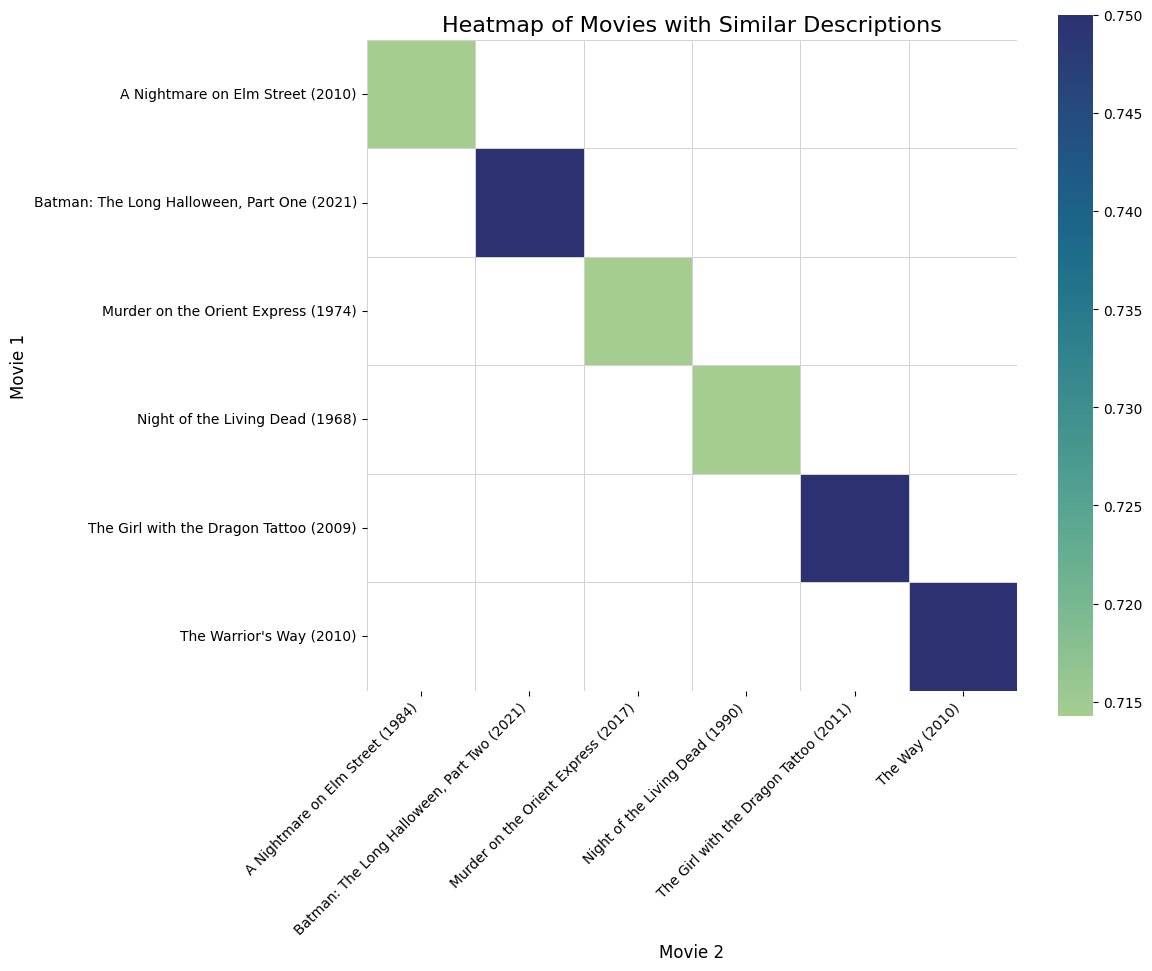

In [29]:
def plot_HeatMap(similar):
    # Extract keys (pairs of movies) and values (similarity scores) from the list of tuples
    key1 = [pair[0] for pair in similar]  # First movie in each tuple
    key2 = [pair[1] for pair in similar]  # Second movie in each tuple
    values = [pair[2] for pair in similar]  # Similarity scores

    # Create a dataframe from the keys and values
    df = pd.DataFrame({'key1': key1, 'key2': key2, 'values': values})

    # Create a pivot table from the dataframe
    df_pivot = df.pivot(index='key1', columns='key2', values='values')

    # Set up the plot
    plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
    sns.heatmap(
        df_pivot,
        cmap='crest',
        annot=False,  # No annotations
        cbar=True,
        mask=df_pivot.isna(),
        linewidths=0.5,  # Add grid lines between cells
        linecolor='lightgray',  # Grid line color
        square=True  # Ensure square cells
    )

    # Customize labels and title
    plt.title('Heatmap of Movies with Similar Descriptions', fontsize=16)
    plt.xlabel('Movie 2', fontsize=12)
    plt.ylabel('Movie 1', fontsize=12)

    # Rotate tick labels for readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_HeatMap(_similar)

### Shingle

In [30]:
def shingle(s, q):
    return {s[i:i+q] for i in range(len(s) - q + 1)}

### Minhashing and Signature

In [31]:
import hashlib
def listhash(shingle, seed):
	return int(hashlib.sha256((shingle + str(seed)).encode('utf-8')).hexdigest(), 16) % 2**32-1

def minhash(shingles, seed):
    return min(listhash(s, seed) for s in shingles)

def signature(shingles, k):
	return [minhash(shingles, seed) for seed in range(k)]

### Signature for entire dataset

In [32]:
descriptions = Movies['Description']
q = 5 # length of shingle  (5 ok for emails)
k = 100 # number of minhashes
keys = [f'{name} ({year})' for name, year in zip(Movies['Name'], Movies['Year'])]
# docs = Movies.set_index('Name')['Description'].to_dict() # dictionary mapping document id to document contents
docs = {key : desc for key, desc in zip(keys, descriptions)}

Observing that there will be an intersection of shingles in documents, this can be used to define the signatures for the entire dataset. Instead of iterating over documents and defining signatures individually, iterate over shingles

In [33]:
def MakeSignatures(docs, shingles, U):
    SIG = {doc : [float('inf') for _ in range(k)] for doc in docs}

    for s in tqdm(U):
        # hashes = signature(s, k)
        hashes = [listhash(s, seed) for seed in range(k)]
        for doc in docs:
            if s in shingles[doc]:
                for i in range(k):
                    SIG[doc][i] = min(hashes[i], SIG[doc][i])
    return SIG

shingles = {doc: shingle(docs[doc], q) for doc in docs}
U = set([s for doc in shingles for s in shingles[doc]])  # All shingles

signatures = MakeSignatures(docs, shingles, U)

100%|██████████| 85912/85912 [01:04<00:00, 1333.67it/s]


### Approximate Jaccard similarity

In [34]:
# Approximate Jaccard similarity using minhash signatures
def approximate_jaccard(A, B, signatures):
    return sum(i == j for i, j in zip(signatures[A], signatures[B])) / k

In [35]:
# Test
A, B = random.sample(keys, 2)
print(A, '-', B)

doc1 = docs[A]
doc2 = docs[B]
shingle1 = shingle(doc1, q)
shingle2 = shingle(doc2, q)
signature1 = signature(shingle1, k)
signature2 = signature(shingle2, k)

# Exact Jaccard similarity
print(jaccard(shingle1, shingle2))

# Approximate Jaccard similarity
print(approximate_jaccard(A, B, signatures))

Sleepless in Seattle (1993) - Brüno (2009)
0.0
0.0


In [36]:
# Find most similar by description
mx = 0.0
most_similar = None
for i, A in enumerate(keys):
    for j in range(i+1, len(keys)):
        B = keys[j]
        # shingle1 = shingle(docs[A], q)
        # shingle2 = shingle(docs[B], q)
        # sim = jaccard(shingle1, shingle2)
        sim = approximate_jaccard(A, B, signatures)
        if sim > mx:
            mx = sim
            most_similar = (A, B)
print(mx, most_similar)
# Jaccard 

0.28 ('Solaris (2002)', 'Solaris (1972)')


In [37]:
A, B = random.sample(keys, 2)
print(A, '-', B)
# Exact Jaccard similarity
print(jaccard(shingle1, shingle2))

# Approximate Jaccard similarity
matches = sum(1 for i, j in zip(signature1, signature2) if i == j)
print(matches)
print(matches / k)
# jaccard(docs[A], docs[B]), approximate_jaccard(A, B, signatures)

Fargo (1996) - The Italian Job (2003)
0.0
0
0.0


### Locality-Sensitive Hashing
Pick $b$ and $r$ such that $k = br$ and $(1/b)^{1/r} \approx s$, where $s$ is the similarity threshold.

In [40]:
# (1/b)**(1/r)

In [38]:
def fill_buckets(signatures, b, r):
    buckets = {i: {} for i in range(b)}
    for doc in signatures:
        for i in range(b):
            h = hash(tuple(signatures[doc][i*r:(i+1)*r]))
            if h not in buckets[i]:
                buckets[i][h] = []
            buckets[i][h].append(doc)
    return buckets

def lsh(signatures, threshold):
    b = 50
    r = k // b
    buckets = fill_buckets(signatures, b, r)

    candidates = set()
    for bucket in buckets:
        for h in buckets[bucket]:
            if len(buckets[bucket][h]) > 1:
                for doc in buckets[bucket][h]:
                    candidates.add(doc)
    candidates = list(candidates)
    
    # Now compare all pairs of candidates
    similar = []
    for i, A in enumerate(candidates):
        for j in range(i+1, len(candidates)):
            B = candidates[j]
            sim = approximate_jaccard(A, B, signatures)
            if sim > threshold:
                similar.append((A, B, sim))
    return similar

_similar = lsh(signatures, 0.22)

### HeatMap

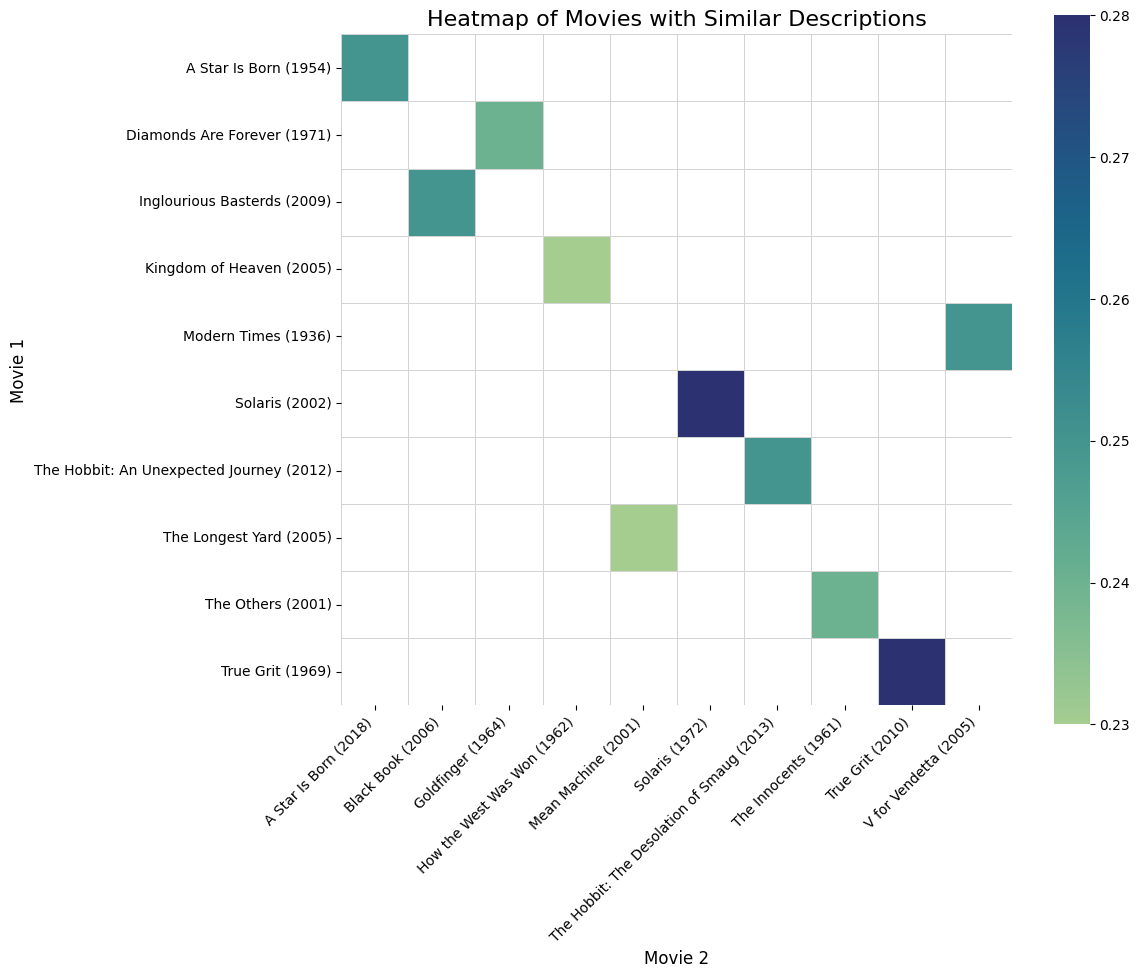

In [39]:
plot_HeatMap(_similar)

# Clustering; Method 2

This alternative method will take the movie contents; (1) Movie name, (2) Movie genres and (3) Movie summary, and tokenize these textual data features using the TF-IDF method, cluster the movies using K-Means Clustering and finally perform recommendations using Cosine Similarity. 

In [55]:
summaries = Movies['Description']
movie_titles = Movies['Name']
genres = pd.DataFrame(Movies['Genre'])
genres = genres['Genre'].str.replace('Sci-Fi', 'Scifi')


summaries_preprocessed = simple_preprocess_text(summaries)
summaries_preprocessed = preprocessing_lemmatization(summaries_preprocessed)

movie_titles_preprocessed = simple_preprocess_text(movie_titles)
movie_titles_preprocessed = preprocessing_lemmatization(movie_titles_preprocessed)

genres_preprocessed = simple_preprocess_text(genres)
genres_preprocessed = preprocessing_lemmatization(genres_preprocessed)


tfidf_vector1 = TfidfVectorizer(min_df=0.015)
summary_result = tfidf_vector1.fit_transform(summaries_preprocessed)

tfidf_vector2 = TfidfVectorizer(min_df=0.005)
movie_titles_result = tfidf_vector2.fit_transform(movie_titles_preprocessed)

tfidf_vector3 = TfidfVectorizer(min_df=0.05)
genres_result = tfidf_vector3.fit_transform(genres_preprocessed)

combined_results = hstack((summary_result, movie_titles_result, genres_result))

C:\Users\User\AppData\Local\Temp\ipykernel_12568\1953410784.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]


In [56]:
tfidf_df_summary = pd.DataFrame(summary_result.toarray(), columns=tfidf_vector1.get_feature_names_out())
tfidf_df_summary

,agent,american,another,attempt,back,battle,become,begin,best,boy,...,war,way,whose,wife,woman,work,world,year,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.535071,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.425177,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.314489,0.0,0.0,...,0.0,0.0,0.0,0.612860,0.0,0.0,0.0,0.0,0.000000,0.227677
3061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [45]:
tfidf_df_title = pd.DataFrame(movie_titles_result.toarray(), columns=tfidf_vector2.get_feature_names_out())
tfidf_df_title

,american,batman,big,black,dark,day,dead,death,dragon,game,...,movie,night,one,part,red,story,street,time,war,world
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.699849,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
tfidf_df_genres = pd.DataFrame(genres_result.toarray(), columns=tfidf_vector3.get_feature_names_out())
tfidf_df_genres

,action,adventure,animation,biography,comedy,crime,dark,drama,epic,family,...,horror,mystery,psychological,romance,scifi,supernatural,teen,thriller,tragedy,western
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.801739,0.597674,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.0,0.000000,0.414024,0.000000,0.260682,0.582993,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.648651,0.0
2,0.000000,0.000000,0.0,0.0,0.320971,0.770788,0.493945,0.242656,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.414024,0.000000,0.260682,0.582993,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.648651,0.0
4,0.288221,0.341966,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.717511,0.0,...,0.000000,0.000000,0.229536,0.0,0.402280,0.0,0.0,0.265800,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.856324,0.415337,0.000000,0.0,0.000000,0.0,0.0,0.306927,0.000000,0.0
3060,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.804233,0.000000,0.0,0.000000,0.0,0.0,0.594315,0.000000,0.0
3061,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.804233,0.000000,0.0,0.000000,0.0,0.0,0.594315,0.000000,0.0
3062,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.431440,0.000000,0.0,...,0.000000,0.725532,0.000000,0.0,0.000000,0.0,0.0,0.536156,0.000000,0.0


## Testing PCA of the preprocessed data

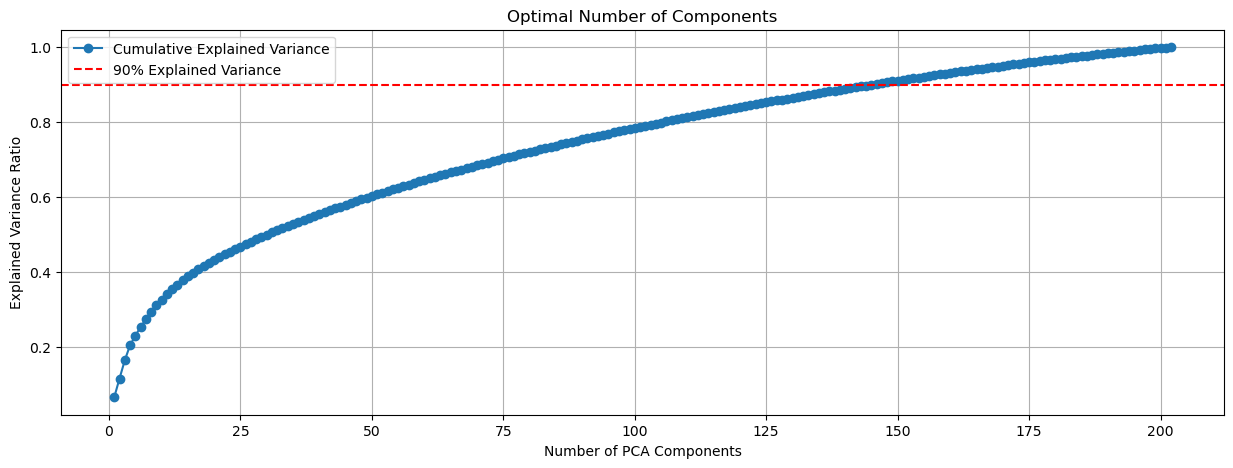

In [ ]:
pca = PCA()
pca.fit(combined_results.toarray())

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(15, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative Explained Variance')

plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Optimal Number of Components')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Explained Variance')
plt.legend(loc='best')
plt.grid()
plt.show()

We can see that the number of components is way to high to use for dimensionality reduction and visualization. It was therefore discarded to move forward with.

## K-Means Clustering
Using the combined TF-IDF results of the two features above, we will apply a K-Means clustering model and in the process use WCSS test to determine the number of cluster to initialize the model with. 
Finally, the clusters will be plotted (using a scatter plot) by utilizing t-SNE for handling the very high dimensionality of the dataset.

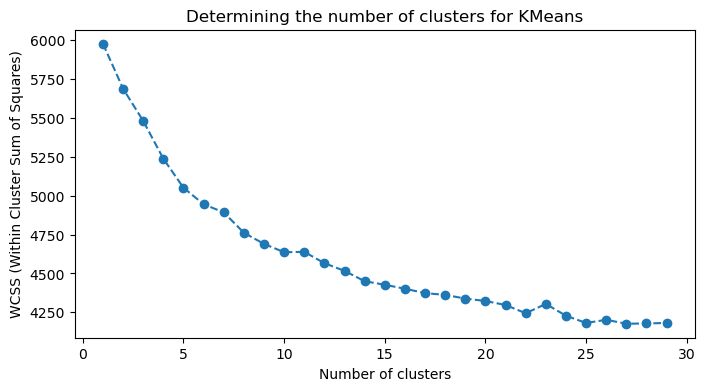

In [60]:
num_clusters = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(combined_results)
    num_clusters.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 30), num_clusters, linestyle = '--', marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Determining the number of clusters for KMeans')
plt.show()

In [69]:
kmeans = KMeans(n_clusters=18, random_state=42)
kmeans.fit(combined_results)
kmeans_labels = kmeans.labels_

db_index = davies_bouldin_score(combined_results.toarray(), kmeans_labels)
print(str.format('Davies-Bouldin Index: {0}', db_index))

Davies-Bouldin Index: 3.214882240463988


### Visualizing the K-Means Clusters with t-SNE

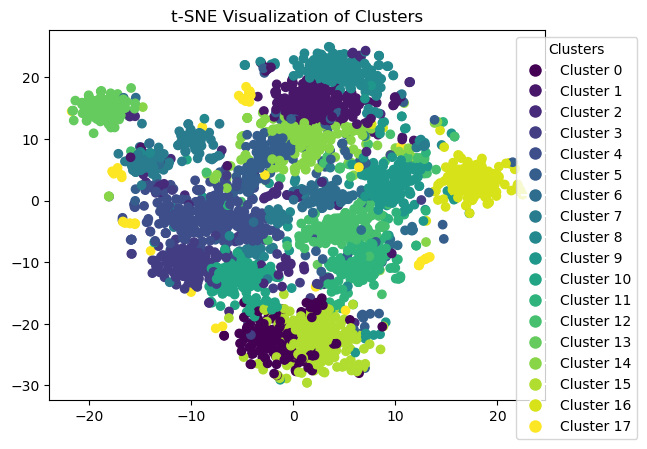

In [70]:
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
tsne_results = tsne.fit_transform(combined_results.toarray())

scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels)

unique_clusters = set(kmeans_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), 
                      markersize=10, label=f'Cluster {i}') for i in unique_clusters]

plt.legend(handles=handles, title="Clusters", loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.title("t-SNE Visualization of Clusters")
plt.show()

## Testing the movie recommendation system
This a simple (and mainly for fun) way of just testing this method by seeing which recommendations you might receive based on what movies you've seen.

In [71]:
total_df = pd.DataFrame(Movies)
total_df['Cluster'] = kmeans_labels
total_df.drop(['ID', 'Length', 'Year', 'Rating', 'Age'], axis=1, inplace=True)

tfidf_df = pd.DataFrame(combined_results.toarray())

In [ ]:
# Get recommendation function:
def getRecommendations(movieIndex):
    inputMovieCluster = total_df.loc[movieIndex, 'Cluster']
    inputMovieName = total_df.loc[movieIndex, 'Name']
    inputMovie = tfidf_df.iloc[[movieIndex]]
    print(str.format('Based on the movie: {0}, we recommend the following:', inputMovieName))

    allClusterMovies = total_df[total_df['Cluster'] == inputMovieCluster]
    recommendations = pd.DataFrame(allClusterMovies)
    recommendations['Similarity'] = -euclidean_distances(inputMovie, tfidf_df[total_df['Cluster'] == inputMovieCluster]).flatten()
    recommendations.drop([movieIndex], inplace=True)
    recommendedMovies = recommendations.sort_values(by='Similarity', ascending=False)

    recommend5Movies = recommendedMovies.head(5)
    for movie, index in zip(recommend5Movies['Name'], range(len(recommend5Movies['Name']))):
            print(str.format('{0}) {1}', index+1, movie))


In [86]:
seenMovie = random.randrange(len(total_df))
getRecommendations(seenMovie)

Based on the movie: Mind Game, we recommend the following:
1) Lady and the Tramp
2) Shrek
3) Hoodwinked
4) Ice Age
5) No Game No Life: Zero


# Social Network

In [69]:
# Compute Weighted Rating (WR)
def Bayesian_weighted_average(movies, n):
    """
        get n most popular movies using Bayesian weighted average based on rating and votes:
        WR = v/(v + m) * R + m/(v + m) * C

        where:
        R: Average rating of the movie (Rating_value).
        v: Number of votes for the movie (votes).
        m: Minimum votes required to be considered (e.g., 80th percentile of votes).
        C: Mean rating across all movies.
    """

    C = movies['Rating_value'].mean()

    if n < len(movies):
        q = 1 - (n / len(movies))
        m = movies['votes'].quantile(q)  # 80th percentile as threshold
    else:
        m = 1

    # Filter movies with at least `m` votes
    qualified_movies = movies[movies['votes'] >= m]

    # Compute Weighted Rating (WR)
    def weighted_rating(x, m=m, C=C):
        v = x['votes']
        R = x['Rating_value']
        return (v / (v + m) * R) + (m / (v + m) * C)

    qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)

    # Sort by Weighted Rating and select Top n
    top_movies = qualified_movies.sort_values('score', ascending=False).head(n)

    # reset the index
    top_movies.reset_index(drop=True, inplace=True)

    return top_movies

In [70]:
# To pick the top n movies from the dataset we use
# Bayesian weighted average on rating_value and votes combined
# n is the number of movies to be picked
top_movies = Bayesian_weighted_average(Movies, 105)

C:\Users\nojan\AppData\Local\Temp\ipykernel_32380\1188794299.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)


In [71]:
# Create TF-IDF on summary plot, Genre and combined Directors and Stars
text_content = simple_preprocess_text(top_movies['Description'])
text_genre = simple_preprocess_text(top_movies['Genre'])
text_Stars = simple_preprocess_text(top_movies['Directors'] + top_movies['stars'])

text_content = preprocessing_lemmatization(text_content)
text_genre = preprocessing_lemmatization(text_genre)
text_Stars = preprocessing_lemmatization(text_Stars)

In [72]:
# Create a TF-IDF vectorizer
vector_c = TfidfVectorizer()
vector_ge = TfidfVectorizer()
vector_stars = TfidfVectorizer()

tf = vector_c.fit_transform(text_content)
tf_genre = vector_ge.fit_transform(text_genre)
tf_stars = vector_stars.fit_transform(text_Stars)

In [73]:
# Create the clusters using K-means on Summary plot, Genre and combined Directors and stars
# clusters for summary plot
n= 105
kmean = KMeans(n_clusters = round(n / 10), random_state=0, n_init="auto")
kmean.fit(tf)

# Cluster for genre
kmean_ge = KMeans(n_clusters= 19, random_state=0, n_init="auto")
kmean_ge.fit(tf_genre)

# Cluster for stars
kmean_st = KMeans(n_clusters= round(n / 3), random_state=0, n_init="auto")
kmean_st.fit(tf_stars)

KMeans(n_clusters=35, random_state=0)

In [74]:
# convert summary plot, genre and combined directors and stars to vector
des_vec = vector_c.transform(top_movies['Description'])
ge_vec = vector_ge.transform(top_movies['Genre'])
st_vec = vector_stars.transform(top_movies['Directors'] + top_movies['stars'])

# Assign movie to cluster
c = kmean.predict(des_vec)
k = kmean_ge.predict(ge_vec)
st = kmean_st.predict(st_vec)


In [75]:
# Replace the summary plot, Genre and combined Director and stars
# with their respective assigned cluster in the dataframe of top movies
top_movies['Description'] = c
top_movies['Genre'] = k
top_movies['Directors'] = st


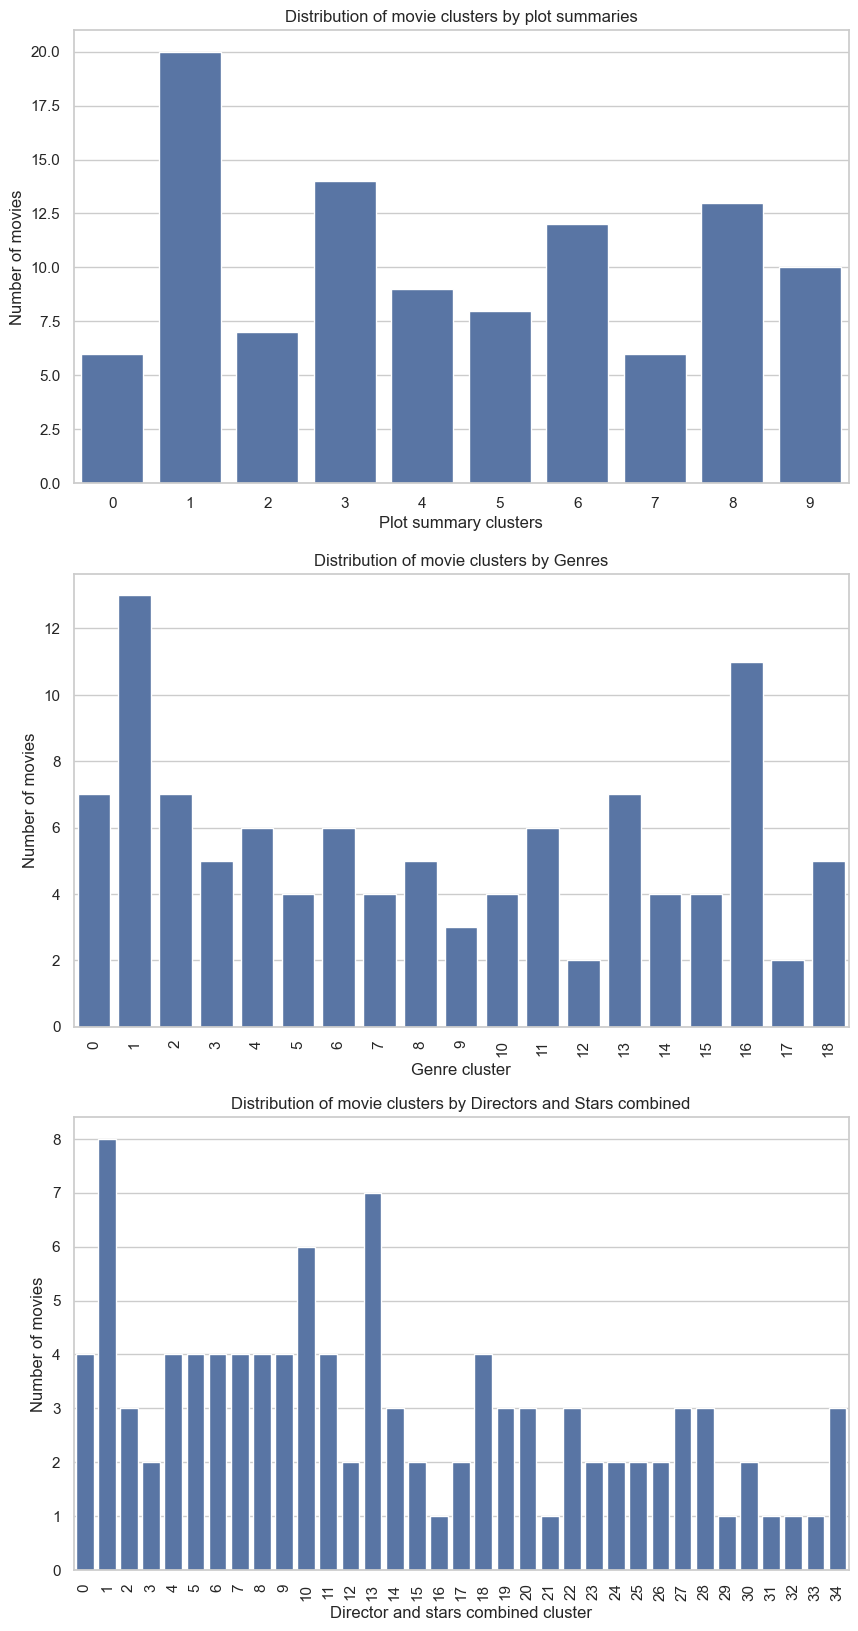

In [76]:
# Visualization of the movie distribution on how the movies
# the movies got assigned in clustering
def show_distrubtion(top_movies):
    """
    Plots the distribution of how the movies are assigned to the different clusters in:
    summary plot, Genre and Directors/stars
    """
    # Set the style for the plots
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 20))

    # Plot for clusters
    plt.subplot(3, 1, 1)
    sns.countplot(x='Description', data=top_movies)
    plt.xlabel('Plot summary clusters')
    plt.ylabel('Number of movies')
    plt.title("Distribution of movie clusters by plot summaries")
    plt.xticks(rotation=0)

    # Plot for categories
    plt.subplot(3, 1, 2)
    sns.countplot(x='Genre', data=top_movies)
    plt.xlabel('Genre cluster')
    plt.ylabel('Number of movies')
    plt.title("Distribution of movie clusters by Genres")
    plt.xticks(rotation=90)

    # Plot for categories
    plt.subplot(3, 1, 3)
    sns.countplot(x='Directors', data=top_movies)
    plt.xlabel('Director and stars combined cluster')
    plt.ylabel('Number of movies')
    plt.title("Distribution of movie clusters by Directors and Stars combined")
    plt.xticks(rotation=90)

    plt.savefig("distribution_of_clusters.png", format="PNG", bbox_inches="tight")  # Save the plot to a file

    plt.show()
show_distrubtion(top_movies)

In [78]:
# Create the movie graph drawing connection between the movies
# using the clustered Summary plot, Genre, combined directors and stars
# and similarity to the top 5 most similar movies based of the genre clustering
import networkx as net


def create_graph(movies, tf, top_n = 5):
    """
    Creates a network graph representing relationships between movies, directors/stars, genres,
    summary plot, and similar movies based on cosine similarity.

    The function uses the NetworkX library to build a graph where:
        - Nodes represent movies, directors/stars, genres, and summary plot.
        - Edges represent relationships, such as "directed by," "belongs to genre,"
          "has description," and "is similar to."

    Method:
        1. Adds nodes for movies with attributes such as name and Bayesian weighted score.
        2. Adds nodes for directors/stars, genres, and summary plot if they do not already exist.
        3. Connects movies to their directors/stars, genres, and descriptions via edges.
        4. Uses cosine similarity to find the `top_n` most similar movies for each movie,
           connecting them with labeled edges.
    """
    # Use network Analysis library NetworkX
    graph = net.Graph()

    # Create the graph
    for i, movie in movies.iterrows():
        # add the nodes (score is the calculated Bayesian weighted average based on rating_value and votes)
        graph.add_node(movie['Name'], key=movie['Name'], label = 'Movie', rating = movie['score'])

        # add nodes for the directors and movies
        if not graph.has_node(movie['Directors']):
            graph.add_node(movie['Directors'], label = 'Directors')

        # add genre and connect them
        if not graph.has_node(movie['Genre']):
            graph.add_node(movie['Genre'], label = 'Genre')

        if not graph.has_node(movie['Description']):
            graph.add_node(movie['Description'], label = 'Description')

        # add edges between movie names and summary plot
        # Add edges between Genre and Name
        # Add edges betwen Genre and Directors/stars
        graph.add_edge(movie['Name'], movie['Directors'])
        graph.add_edge(movie['Name'], movie['Description'])
        graph.add_edge(movie['Name'], movie['Genre'])

        # find the top top_n most similar movies based on genre
        cosine_similarities = cosine_similarity(tf[i:i + 1], tf).flatten()
        related_docs_indices = sorted(range(len(cosine_similarities)), key=cosine_similarities.__getitem__,
                                      reverse=True)
        similar_movies = [idx for idx in related_docs_indices if idx != i][:top_n]

        for j in similar_movies:
            graph.add_edge(movie['Name'], movies['Name'].loc[j], label = 'similar')

    return graph
graph = create_graph(top_movies, tf_genre)

In [79]:

def adamic_adar_index(graph, movie_seen, recommended_movie):
    """
    Calculates the Adamic-Adar index for two movies in a graph.

    The Adamic-Adar index measures the similarity between two nodes based on their
    shared neighbors. It assigns higher weight to neighbors with fewer connections
    (less common nodes), emphasizing unique relationships.

    Formula:
        Adamic-Adar score = Σ (1 / log(degree(neighbor)))

    Where:
        - `neighbor` is a common neighbor of `movie_seen` and `recommended_movie`.
        - `degree(neighbor)` is the number of edges connected to the neighbor.
    """
    # Get the neighbors of both movies
    common_neighbors = set(graph.neighbors(movie_seen)).intersection(graph.neighbors(recommended_movie))

    # Calculate the Adamic-Adar weight based on common neighbors
    return sum(1 / math.log(graph.degree(neighbor)) for neighbor in common_neighbors if graph.degree(neighbor) > 1)


In [80]:

def get_recommendations(graph, movie_seen, top_n=5):
    """
    Generates movie recommendations based on the Adamic-Adar index using a network graph.

    This function identifies movies related to the given movie (`movie_seen`) by analyzing
    the graph structure. It calculates the Adamic-Adar index for second-degree neighbors
    (movies connected through shared nodes) and ranks them to recommend the top `n` movies.

    1. Traverses the graph to identify second-degree neighbors of the `movie_seen` node.
    2. Filters nodes to include only movies that have not already been recommended.
    3. Computes the Adamic-Adar index to measure similarity between `movie_seen` and candidate movies.
    4. Returns the top `n` recommendations based on the highest scores.

    return A sorted list of recommended movies with their Adamic-Adar scores.
    """
    recommendations = []
    already_seen_movies = set()

    # Loop through neighbors of the movie seen
    for neighbor_inner in graph.neighbors(movie_seen):
        # Loop through neighbors of neighbors (second-degree neighbors)
        for neighbor_outer in graph.neighbors(neighbor_inner):
            # Find common neighbors now for the adamic adar index
            if neighbor_outer == movie_seen:
                continue  # Skip if the node is the movie seen:

            # Check if it's a movie node and not already visited
            if 'label' in graph.nodes[neighbor_outer] and graph.nodes[neighbor_outer]['label'] == "Movie":
                if neighbor_outer not in already_seen_movies:
                    # Calculate Adamic-Adar score and add to recommendations
                    score = adamic_adar_index(graph, movie_seen, neighbor_outer)
                    recommendations.append((neighbor_outer, score))

                    # add to keep track movie has been seen
                    already_seen_movies.add(neighbor_outer)

    # Sort by score and return top N recommendations
    return sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_n]


In [82]:

# To get recommendation from the graph using the adamic adar index
# top_n = 5
import math
movie_seen = "Toy Story"
recommended_movies = get_recommendations(graph, movie_seen, top_n=5)
print(recommended_movies)

[('Toy Story 3', 2.7513362684672416), ('Up', 2.713249046578069), ('Finding Nemo', 2.206571965965512), ('Monsters, Inc.', 2.173571970558749), ('The Lion King', 2.1152151127263688)]


In [83]:

def plot_graph_n_recommended(graph, recommended_list, seen_movie):
    """
    Highlight the recommended way on the graph from the seen movie
    """
    # Set up the figure size
    plt.figure(figsize=(15, 15))

    # Prepare node sizes, colors, and labels
    sizes = []
    colors = []
    label_vec = {}
    seen_movie_nodes = set([seen_movie])  # Set to track seen movie node
    recommended_movie_nodes = set([movie for movie, _ in recommended_list])  # Set for recommended movie nodes
    highlighted_edges = []  # List to track edges between the seen movie and recommended movies

    # Iterate through the nodes to apply sizes, colors, and labels
    for node, attributes in graph.nodes(data=True):
        if 'label' in attributes and attributes['label'] == 'Movie':
            label_vec[node] = node  # Add the movie name to the labels

            # Check if it's the seen movie or a recommended movie
            if node == seen_movie:
                sizes.append(500)  # Larger size for the seen movie
                colors.append('green')  # Color for the seen movie
            elif node in recommended_movie_nodes:
                sizes.append(400)  # Medium size for the recommended movies
                colors.append('yellow')  # Color for the recommended movies
            else:
                sizes.append(100)  # Default size for other movie nodes
                colors.append('red')  # Default color for non-highlighted movie nodes
        else:
            sizes.append(10)  # Default size for non-movie nodes (e.g., genres, directors)
            colors.append('grey')  # Color for non-movie nodes

    # Identify edges between the seen movie and the recommended movies
    for recommended_movie, _ in recommended_list:
        if graph.has_edge(seen_movie, recommended_movie):
            highlighted_edges.append((seen_movie, recommended_movie))

    # Layout of the graph (using Kamada-Kawai layout)
    pos = net.kamada_kawai_layout(graph)

    # Draw the graph
    net.draw(graph, pos=pos, node_size=sizes, node_color=colors, with_labels=False, alpha=0.6, width=0.5,
            edge_color='grey')

    # Draw the labels for all nodes (movies, directors, genres, etc.)
    net.draw_networkx_labels(graph, pos, labels=label_vec, font_size=12, font_color='black')

    # Highlight the seen movie in green and recommended movies in yellow
    net.draw_networkx_nodes(graph, pos, nodelist=seen_movie_nodes, node_size=600, node_color='green', edgecolors='black')
    net.draw_networkx_nodes(graph, pos, nodelist=recommended_movie_nodes, node_size=400, node_color='yellow',
                           edgecolors='black')

    # Highlight the edges between the seen movie and recommended movies in blue
    net.draw_networkx_edges(graph, pos, edgelist=highlighted_edges, edge_color='blue', width=2)

    # Show the plot
    plt.title("Movie Network with Seen and Recommended Movies Highlighted")
    plt.axis('off')
    plt.savefig("highlighted_network_of_movies.png", format="PNG", bbox_inches="tight")  # Save the plot to a file
    plt.show()

In [84]:

def plot_simpel_recommended_movies(recommended_movies, seen_movie):
    """
    Simple plot to showcase the recommended movies based and the adamic adar index based on the "seen_movie"
    """
    # Simpel plot of the recommended movies
    movie_names = [movie[0] for movie in recommended_movies]
    scores = [movie[1] for movie in recommended_movies]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(movie_names, scores, color='skyblue')

    # Set the labels and title
    plt.ylabel('Adamic Adar Score')
    plt.title(f'Recommended Movies Based on: {seen_movie}')

    # Rotate x-axis labels to make them readable
    plt.xticks(rotation=10, ha='right')

    plt.savefig("Adamic_adar_plot.png", format="PNG", bbox_inches="tight")  # Save the plot to a file

    # Show the plot
    plt.show()

def create_graph(movies, tf, top_n = 5):
    """
    Creates a network graph representing relationships between movies, directors/stars, genres,
    summary plot, and similar movies based on cosine similarity.

    The function uses the NetworkX library to build a graph where:
        - Nodes represent movies, directors/stars, genres, and summary plot.
        - Edges represent relationships, such as "directed by," "belongs to genre,"
          "has description," and "is similar to."

    Method:
        1. Adds nodes for movies with attributes such as name and Bayesian weighted score.
        2. Adds nodes for directors/stars, genres, and summary plot if they do not already exist.
        3. Connects movies to their directors/stars, genres, and descriptions via edges.
        4. Uses cosine similarity to find the `top_n` most similar movies for each movie,
           connecting them with labeled edges.
    """
    # Use network Analysis library NetworkX
    graph = net.Graph()

    # Create the graph
    for i, movie in movies.iterrows():
        # add the nodes (score is the calculated Bayesian weighted average based on rating_value and votes)
        graph.add_node(movie['Name'], key=movie['Name'], label = 'Movie', rating = movie['score'])

        # add nodes for the directors and movies
        if not graph.has_node(movie['Directors']):
            graph.add_node(movie['Directors'], label = 'Directors')

        # add genre and connect them
        if not graph.has_node(movie['Genre']):
            graph.add_node(movie['Genre'], label = 'Genre')

        if not graph.has_node(movie['Description']):
            graph.add_node(movie['Description'], label = 'Description')

        # add edges between movie names and summary plot
        # Add edges between Genre and Name
        # Add edges betwen Genre and Directors/stars
        graph.add_edge(movie['Name'], movie['Directors'])
        graph.add_edge(movie['Name'], movie['Description'])
        graph.add_edge(movie['Name'], movie['Genre'])

        # find the top top_n most similar movies based on genre
        cosine_similarities = cosine_similarity(tf[i:i + 1], tf).flatten()
        related_docs_indices = sorted(range(len(cosine_similarities)), key=cosine_similarities.__getitem__,
                                      reverse=True)
        similar_movies = [idx for idx in related_docs_indices if idx != i][:top_n]

        for j in similar_movies:
            graph.add_edge(movie['Name'], movies['Name'].loc[j], label = 'similar')

    return graph

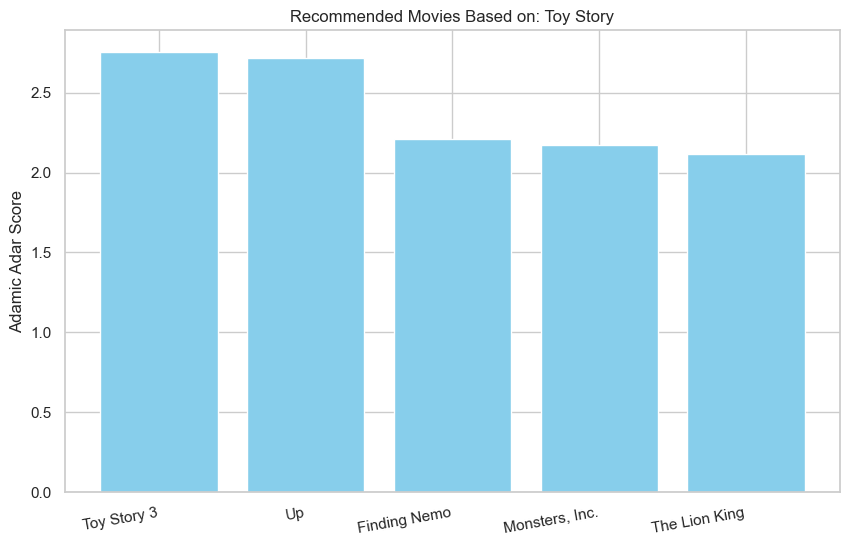

In [85]:
    # Plot the recommended movies based on the already "seen movie"
    # displaying highest scoring adamic adar index and movies
    plot_simpel_recommended_movies(recommended_movies, movie_seen)

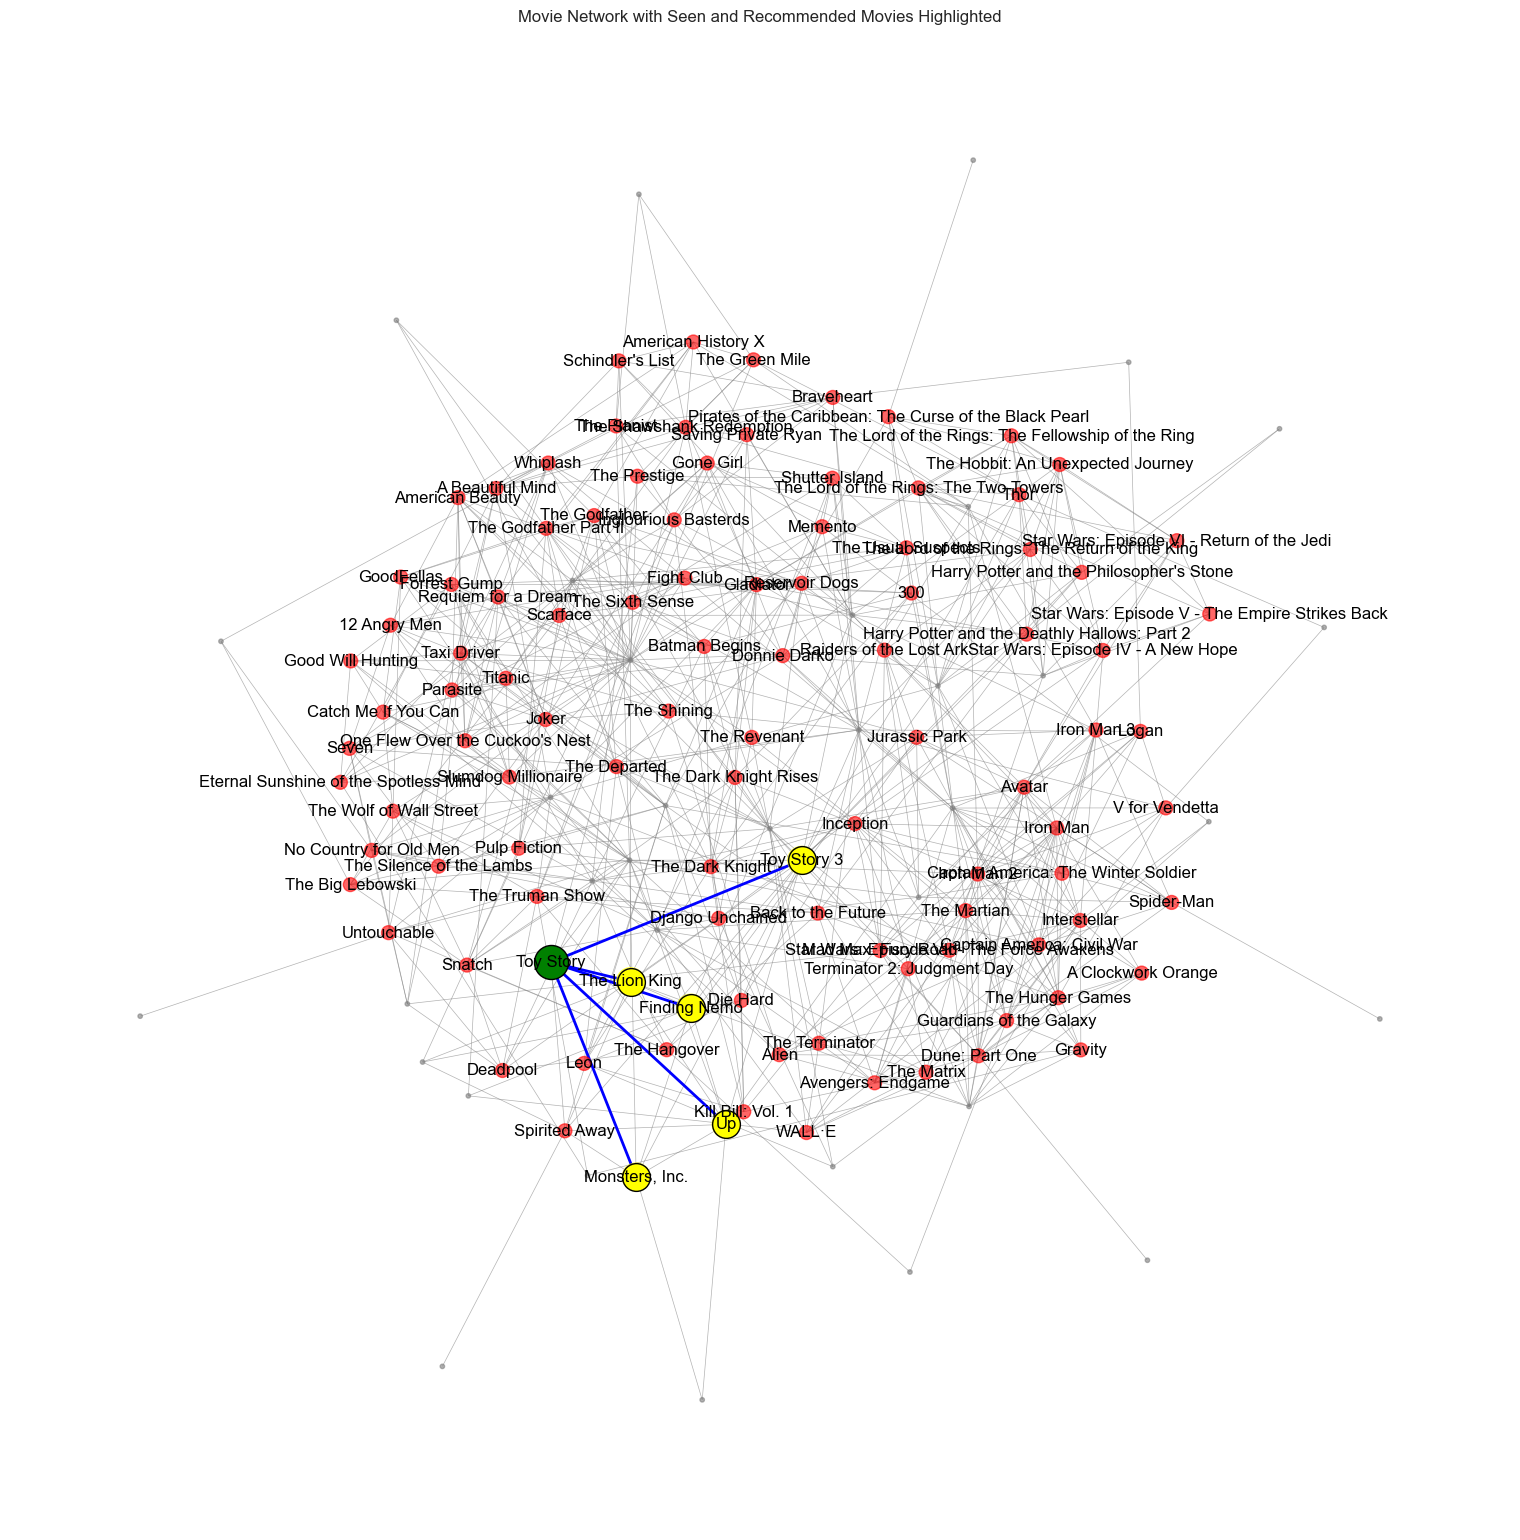

In [86]:
    # Display the Network graph where the seen movie is highlighted green
    # and recommended movies yellow and their paths
    plot_graph_n_recommended(graph, recommended_movies, movie_seen)

# Sentiment Analysis

As part of the movie recommendation idea, we want the end user to have an additional data point for their consideration of our recommendation. 

We have therefore decided to employ a sentiment analysis, based on movie reviews. The sentiment analysis will be based on machine learning, employing different models, trained on a [sentiment-labelled IMDB movie review dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). As part of this, the movie reviews will be preprocessed, and vectorized, using TF-IDF. 
 

In [48]:
reviews = []
reviews =[review for review in kaggle_sentiments['review']]

In [49]:
processed_text= simple_preprocess_text(reviews)
processed_text= preprocessing_lemmatization(processed_text)


C:\Users\nojan\AppData\Local\Temp\ipykernel_32380\1953410784.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]


As shown, the text is now cleaned up, and only the most important words for the sentiment analysis is kept

The next step is to use TF-IDF to extract the most important features from the text. TF stands for term frequency, the frequency of a word appearing in a document. IDF stands for Inverse Document Frequency, which is a weighing method that indicate how commonly a word appears across all the documents, which in our case are the reviews. 

In [50]:
# TF-IDF vectorization,
# which is a way to represent text data as a matrix of numbers
vector = TfidfVectorizer(max_features=5000)
X = vector.fit_transform(processed_text).toarray()
# We will include the sentiment column as the target variable
y = kaggle_sentiments['sentiment'].values

In [51]:
# Split the data into training and testing sets
# 80% of the data will be used for training and 20% for testing
# The random_state parameter is used to ensure that the data is split in the same way every time the code is run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will now be training and testing on different model types, to evaluate which one is best for our purposes

In [52]:
models = {}

In [53]:
# Train a logistic regression model
models['Logistic Regression'] = LogisticRegression()
models['Logistic Regression'].fit(X_train, y_train)

LogisticRegression()

In [54]:
# Train a SVM model
from sklearn.svm import LinearSVC
models['SVM'] = LinearSVC() # faster converge, if linear
models['SVM'].fit(X_train, y_train)

LinearSVC()

In [55]:
# Train a Naive Bayes model
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()
models['Naive Bayes'].fit(X_train, y_train)

GaussianNB()

In [56]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(n_jobs=-1)
models['Random Forest'].fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [57]:
best_model = None
best_accuracy = 0
for model in models:
    y_pred = models[model].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {model}")
    print(f"Accuracy of sentiment prediction: {accuracy}")
    print()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f"The best model is: {best_model}")


Model: Logistic Regression
Accuracy of sentiment prediction: 0.8877

Model: SVM
Accuracy of sentiment prediction: 0.8785

Model: Naive Bayes
Accuracy of sentiment prediction: 0.7882

Model: Random Forest
Accuracy of sentiment prediction: 0.8462

The best model is: Logistic Regression


The results show that the Logistic Regression performs the best on this dataset.
This is the model we will continue with, when we now apply the trained model on our own scrapped movie dataset.
Each movie has 25 reviews attached

In [58]:
import pickle 
with open('reviews.pkl', 'rb') as file:
    custom_data = pd.read_pickle(file)



In [61]:
sentiments = {}
bad_data = []
for title in custom_data:
    temp = (custom_data[title])
    if temp is None:
        bad_data.append(title)
        continue
    else:
        temp = list(temp)

    if temp[0] is None:
        bad_data.append(title)
        continue
    temp= simple_preprocess_text(temp)
    temp= preprocessing_lemmatization(temp)
    temp = vector.transform(temp).toarray()
    sentiment = models[best_model].predict(temp)
    sentiments[title] = sentiment

C:\Users\nojan\AppData\Local\Temp\ipykernel_32380\1953410784.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]
C:\Users\nojan\AppData\Local\Temp\ipykernel_32380\1953410784.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]
C:\Users\nojan\AppData\Local\Temp\ipykernel_32380\1953410784.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]
C:\Users\nojan\AppData\Local\Temp\ipykernel_32380\1953410784.py:3: MarkupResemblesLocatorWarni

In [62]:
print("During sentiment analysis, "+ str(len(bad_data)) + " movies have been removed, due to no reviews")

During sentiment analysis, 315 movies have been removed, due to no reviews


For each movie, the 25 reviews are now scored, predicted to be either positive or negative by our model. 
We normalize the score to a value between 0 and 1, 0 being no positive review and 1 being all positive.

In [63]:
sentiment_scores = {}
for title in sentiments:
    temp = sentiments[title]
    temp_score = (np.count_nonzero(temp == "positive"))
    sentiment_scores[title] = temp_score/len(temp)

To get an idea of how accurate this is, we will compare the global rating of a movie, to its sentiment score.

In [64]:
Movie_scores = Movies.set_index("ID")["Rating"].to_dict()

In [65]:
# Normalize the scores, as they are in the range 0-10
Movie_scores = {key: (float(value.split(" ")[0]))/10. for key, value in Movie_scores.items()}

In [66]:
# We want to remove movies that have no sentiment scores
for title in bad_data:
    Movie_scores.pop(title, None)

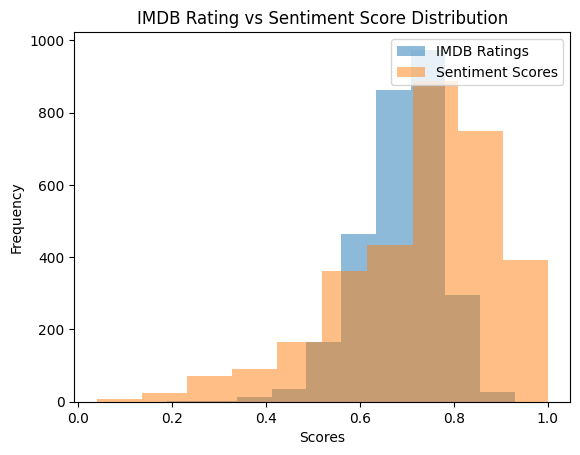

In [67]:
# plot histogram of both ratings and sentiment scores
plt.hist(Movie_scores.values(), bins=10, alpha=0.5, label='IMDB Ratings')
plt.hist(sentiment_scores.values(), bins=10, alpha=0.5, label='Sentiment Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('IMDB Rating vs Sentiment Score Distribution')
plt.legend(loc='upper right')
plt.show()

Both histograms shows a left skewered distribution, as most of the observations lie to the right of 0.5 sentiment.
This makes sense, as the data is mostly scrapped from IMDB lists over the most popular movies.

We see that the actual IMDB ratings are more so centered around 0.7, while the sentiment score frequencies are more even across the upper end of the scale.
The reason for this is probably two-fold:

One reason is that we have taken just 25 user reviews, a rather small sample, while the IMDB ratings is an average over a much larger sample.
The exact 25 user reviews can therefore skewer the ratings quite significantly.

The other reason is that the sentiments for the reviews are binarily classified, they can be either positive or negative. The actual IMDB ratings use a 0-10 scale, which allows much more variance in rating.

In [68]:
# We want to compare the sentiment scores with the actual ratings
# We will use the Pearson correlation coefficient to measure the linear relationship strength between the two variables
# The coefficient ranges from -1 to 1, where 1 means a strong positive linear relationship, -1 means a strong negative linear relationship, and 0 means no linear relationship
from scipy.stats import pearsonr
sentiment_scores = {key: value for key, value in sentiment_scores.items() if key in Movie_scores}
ratings = [Movie_scores[key] for key in sentiment_scores]
sentiments = [sentiment_scores[key] for key in sentiment_scores]

correlation, _ = pearsonr(ratings, sentiments)
print(f"Pearson correlation coefficient: {correlation}")


Pearson correlation coefficient: 0.7584781955400373


The Pearson correlation is close to 1, indicating that our calculated sentiment scores are highly linearly correlated with the IMDB scores